<Figure size 1000x600 with 0 Axes>

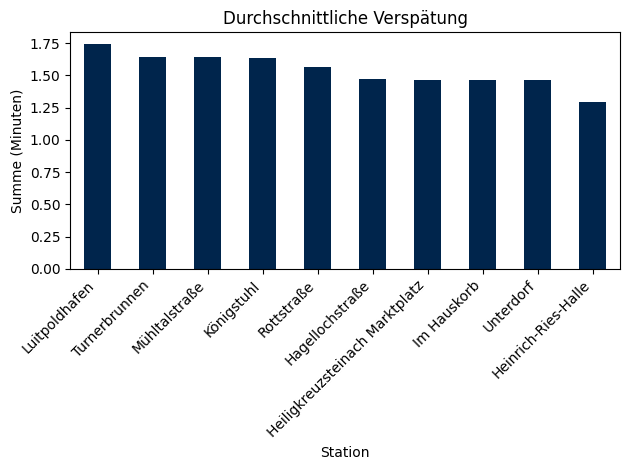

In [3]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import pymysql
import cProfile

db = pymysql.connect(host="localhost", user="rnv_importer", password="rnv_importer", database="rnv_big_data_mining")
cursor = db.cursor()

cursor.execute("SELECT id from journeys;")
journeys = cursor.fetchall()

station = []
delay = []
stopAmount = []
averageDelay = []

for journey in journeys:
    cursor.execute("SELECT api_station, api_plannedDeparture, api_realtimeDeparture from stops where api_journey = %s ORDER BY api_plannedDeparture ASC;", journey)
    stops = cursor.fetchall()
    if stops:
        stop_list = list(stops)
        stop_list.pop(0) #has value null because the last stop doesn't have a departure
        laststops_rt_lat = None
        for stop in stop_list:
            
            if stop[1] is None or stop[2] is None:
                break              
            station_id = stop[0]
            planned_departure = stop[1].timestamp()
            realtime_departure = stop[2].timestamp()

            #add or update station 
            if station_id in station:
                #station already exists -> update values
                index = station.index(station_id)
                if laststops_rt_lat is None:
                    delay[index] += (realtime_departure - planned_departure)
                    laststops_rt_lat = (realtime_departure - planned_departure)
                else:
                    delay[index] += (realtime_departure - (planned_departure + laststops_rt_lat))
                    laststops_rt_lat = (realtime_departure - (planned_departure + laststops_rt_lat))
                stopAmount[index] += 1
            else:
                # station doesn`t exist jet -> add station
                station.append(station_id)
                if laststops_rt_lat is None:
                    delay.append(realtime_departure - planned_departure)
                    laststops_rt_lat = (realtime_departure - planned_departure)
                else:
                    delay.append(realtime_departure - (planned_departure + laststops_rt_lat))
                    laststops_rt_lat = (realtime_departure -(planned_departure + laststops_rt_lat))
                stopAmount.append(1)
            

station_sums = {}
    
for station_id in station:
    index = station.index(station_id)

    total_delays = delay[index]
    total_stops = stopAmount[index]
    average_delay = total_delays / total_stops
    averageDelay.append(average_delay)
    station_sums[station_id] = average_delay
    #debug output
    #print(f"Station: {station_id}, Anzahl stops: {total_stops}, durchschnittliche Verspätung: {average_delay}s, gesamte Verspätung(absolut): {total_delays}")

station_sums = dict(sorted(station_sums.items(), key=lambda item: item[1], reverse=True))
df = pd.DataFrame(list(station_sums.items()), columns=['Station', 'Durchschnittliche Verspätung'])
df['Station'] = [cursor.execute("SELECT api_longName FROM stations WHERE api_hafasID = %s;", (station_id,)) and cursor.fetchone()[0] for station_id in df['Station']]
df['Durchschnittliche Verspätung'] /= 60

plt.figure(figsize=(10, 6))  # adjust chart size
ax = df.head(10).plot(kind="bar", x='Station', y='Durchschnittliche Verspätung', rot=45, align='center', legend=False, color='#00254C')  # rotate and center
plt.xlabel('Station')
plt.ylabel('Summe (Minuten)')
plt.title('Durchschnittliche Verspätung')
plt.xticks(rotation=45, ha='right')  # rotate and align right
plt.tight_layout()  # improve layout
plt.show()